In [1]:
import os
import glob
import json
import h5py

import numpy as np
import pandas as pd
import pylab as pl
import seaborn as sns

from pipeline.python.classifications import utils as util
from pipeline.python.classifications import test_responsivity as resp
from pipeline.python.utils import label_figure, natural_keys


/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/utils.py:10: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()


In [2]:
%matplotlib notebook

In [3]:
reload(util)

/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/utils.py:10: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to u'nbAgg' by the following code:
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/julianarhee/anacond

<module 'pipeline.python.classifications.utils' from '/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/utils.pyc'>

In [3]:
rootdir = '/n/coxfs01/2p-data'

animalid = 'JC085'
session = '20190622'
fov = 'FOV1_zoom2p0x'
traceid = 'traces001'


In [4]:
experiment_name = 'blobs'

In [5]:
# Load data:
trace_type = 'corrected'
exp = util.Experiment(experiment_name, animalid, session, fov, traceid) #, trace_type=trace_type)
exp.load(trace_type=trace_type)

exp.data.traces, exp.data.labels = util.check_counts_per_condition(exp.data.traces, exp.data.labels)
gdf = resp.group_roidata_stimresponse(exp.data.traces, exp.data.labels)

[blobs] creating experiment object.
... [combined_blobs_static] getting data path.
... renaming experiment to run name: combined_blobs_static
... loading data array (combined_blobs_static - datasets.npz)


In [6]:
data_identifier = '|'.join([animalid, session, fov, traceid, experiment_name, trace_type])

In [8]:
excluded_params = []
if experiment_name == 'gratings':
    excluded_params = ['position', 'xpos', 'ypos']
elif experiment_name == 'blobs':
    excluded_params = ['color', 'xpos', 'ypos', 'object']
    fix_cfgs = exp.data.sdf[np.isnan(exp.data.sdf['size'])].index.tolist()
    for cfg in fix_cfgs:
        exp.data.sdf.loc[cfg, 'size'] = 0

all_params = [c for c in exp.data.sdf.columns if c not in excluded_params]
tested_params = [c for c in all_params if len(exp.data.sdf[c].unique()) > 1]
stim_params = dict((str(p), sorted(exp.data.sdf[p].unique())) for p in tested_params)
stim_params

{'morphlevel': [-1, 0, 14, 27, 40, 53, 66, 79, 92, 106],
 'size': [0.0, 10.0, 20.0, 30.0, 40.0, 50.0]}

# ROC analysis + bootstrap shuffle

In [9]:
from sklearn.utils import shuffle

In [10]:
def get_hits_and_fas(resp_stim, resp_bas):
    
    curr_cfg_ixs = range(resp_stim.shape[0])
    n_conditions, n_trials = resp_stim.shape
    min_val = resp_stim.min()
    max_val = resp_stim.max()
    
    crit_vals = np.linspace(min_val, max_val)
    
    p_hits = np.empty((len(curr_cfg_ixs), len(crit_vals)))
    p_fas = np.empty((len(curr_cfg_ixs), len(crit_vals)))
    for ci in range(n_conditions): #range(n_conditions):
        p_hit = [sum(resp_stim[ci, :] > crit) / float(n_trials) for crit in crit_vals]
        p_fa = [sum(resp_bas[ci, :] > crit) / float(n_trials) for crit in crit_vals]
        p_hits[ci, :] = p_hit
        p_fas[ci, :] = p_fa
        
    return p_hits, p_fas, crit_vals


In [12]:
# create output dir:
traces_basedir = exp.source.split('/data_arrays/')[0]
output_dir = os.path.join(traces_basedir, 'summary_stats')

roc_dir = os.path.join(output_dir, 'ROC')
if not os.path.exists(roc_dir):
    os.makedirs(roc_dir)
print("Saving ROC analysis output to:\n--- %s" % roc_dir)

Saving ROC analysis output to:
--- /n/coxfs01/2p-data/JC085/20190622/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_6da5ed_traces001_19b5de_traces001_565a1c_traces001_238b5b_traces001_cb35ec_traces001_6537ce/summary_stats/ROC


In [13]:
sdf = exp.data.sdf

curr_plot_cfgs = sdf.index.tolist()

curr_cfg_ixs = [int(cfg[-3:])-1 for cfg in curr_plot_cfgs]
colors = sns.color_palette('cubehelix', len(curr_plot_cfgs))

In [14]:
# create output dir for roi figures:
roi_figdir = os.path.join(roc_dir, 'rois')
if not os.path.exists(roi_figdir):
    os.makedirs(roi_figdir)

('min/max stim:', -11.231057915419161, 697.36153326502927)
(100, 30)


<IPython.core.display.Javascript object>


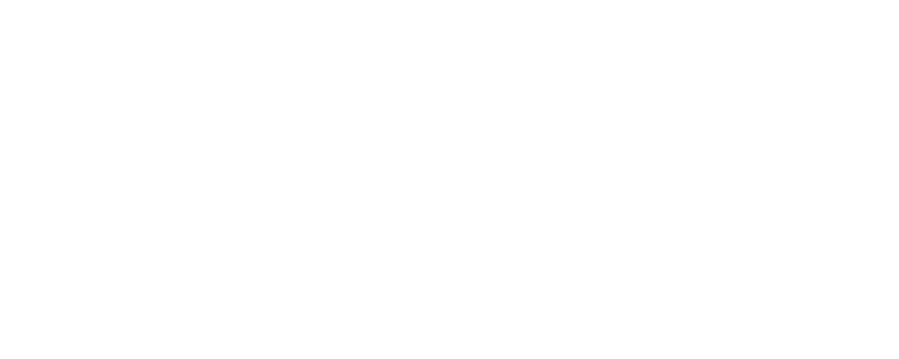

('min/max stim:', 4.0071005292684507, 154.91587698323912)
(100, 30)


<IPython.core.display.Javascript object>


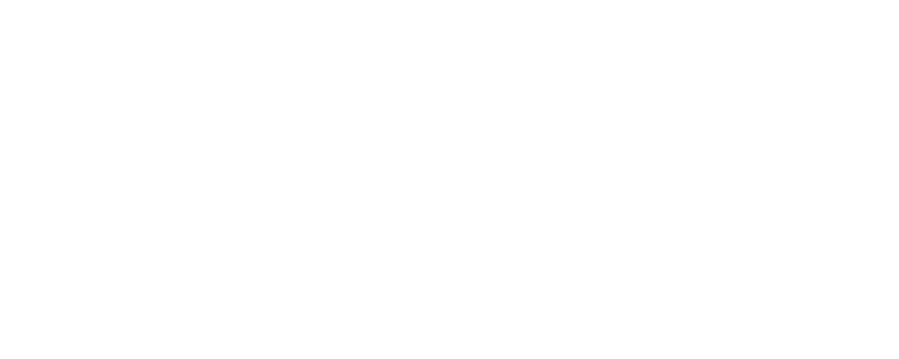

('min/max stim:', 17.918002945210624, 266.64335248116106)
(100, 30)


<IPython.core.display.Javascript object>


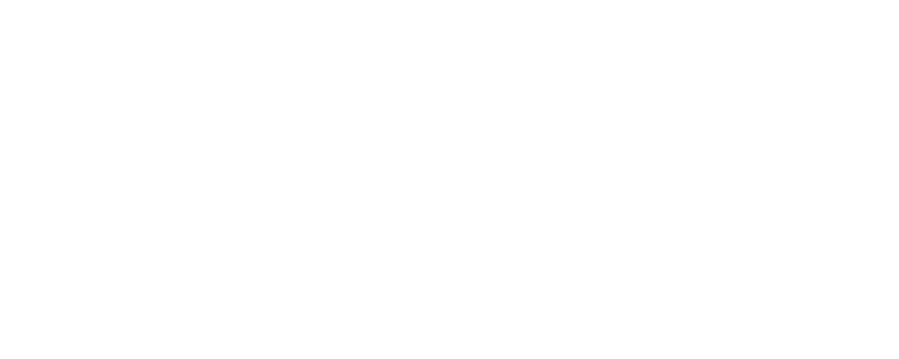

('min/max stim:', 41.173805573322717, 147.48923783963468)
(100, 30)


<IPython.core.display.Javascript object>


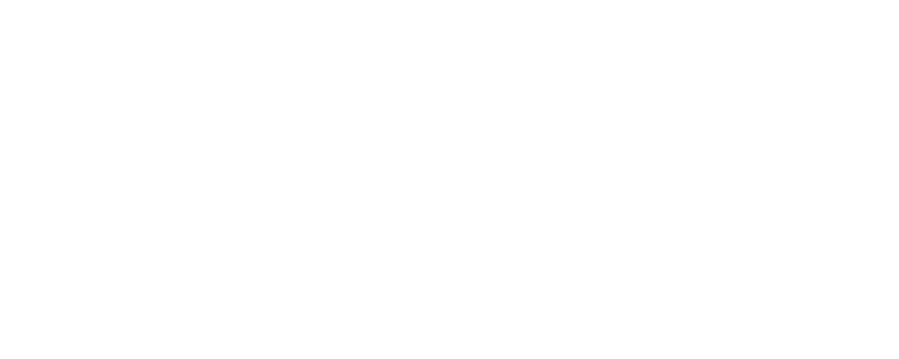

('min/max stim:', 5.2961538862561648, 449.70846486425791)
(100, 30)


<IPython.core.display.Javascript object>


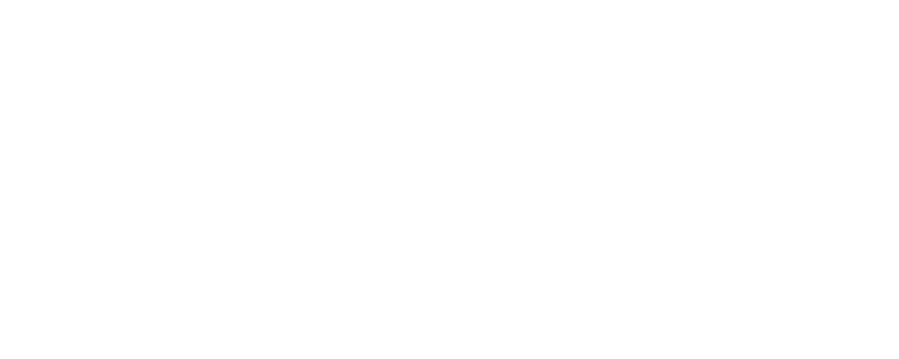

('min/max stim:', 34.894889204786814, 149.12182048339017)
(100, 30)


<IPython.core.display.Javascript object>


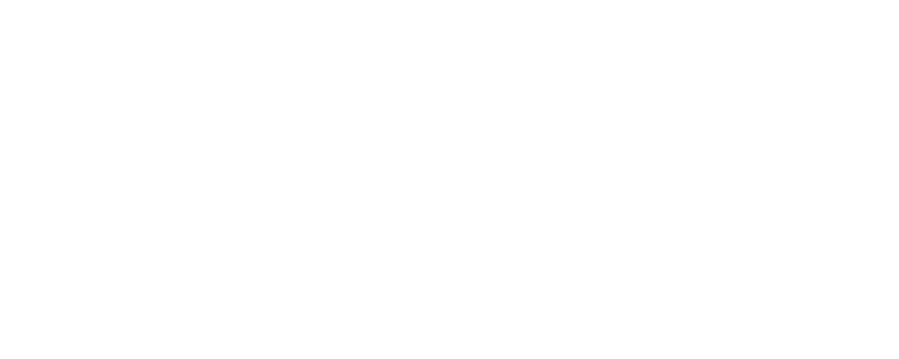

('min/max stim:', 34.392923677884681, 158.8655671515298)
(100, 30)


<IPython.core.display.Javascript object>


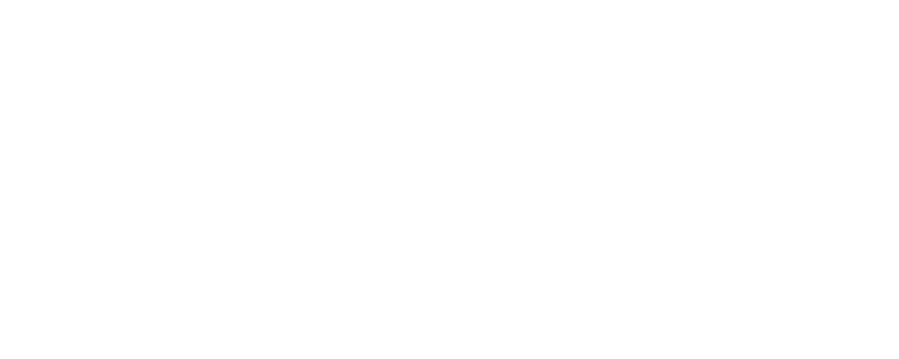

('min/max stim:', 43.308114205549572, 161.36074708904403)
(100, 30)


<IPython.core.display.Javascript object>


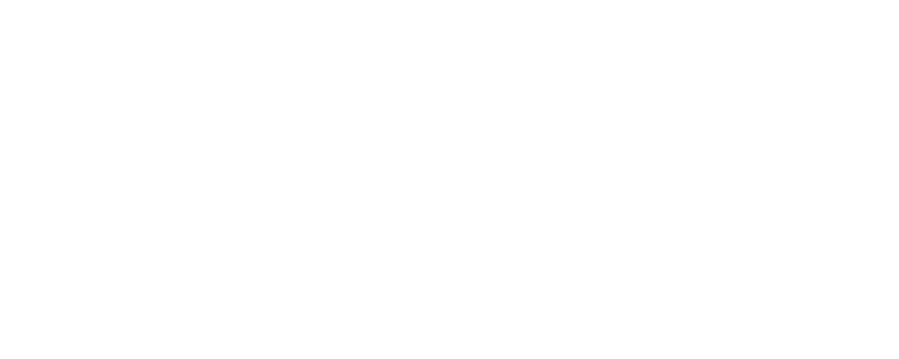

('min/max stim:', -30.774389233821516, 321.85475719053278)
(100, 30)


<IPython.core.display.Javascript object>


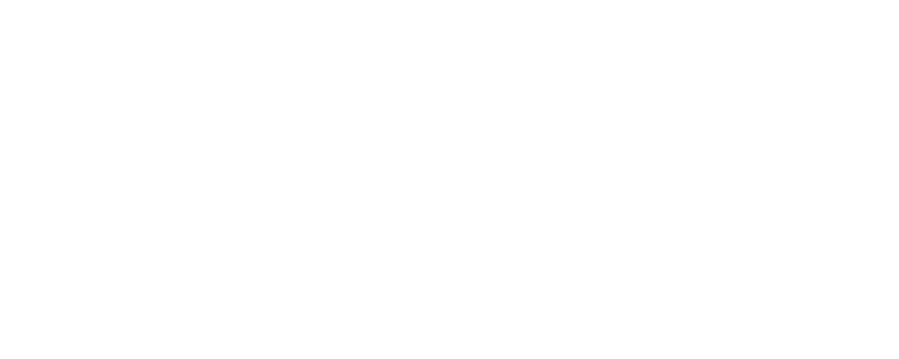

('min/max stim:', -14.982733554968394, 269.60402614224517)
(100, 30)


<IPython.core.display.Javascript object>


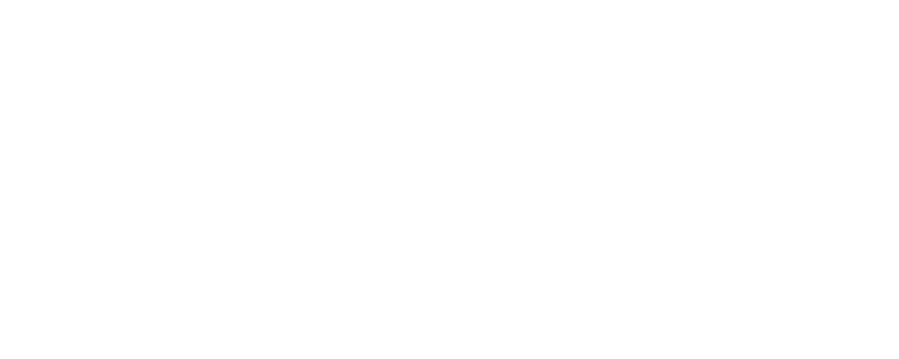

('min/max stim:', -1.8968214054768384, 588.02118289262796)
(100, 30)


<IPython.core.display.Javascript object>


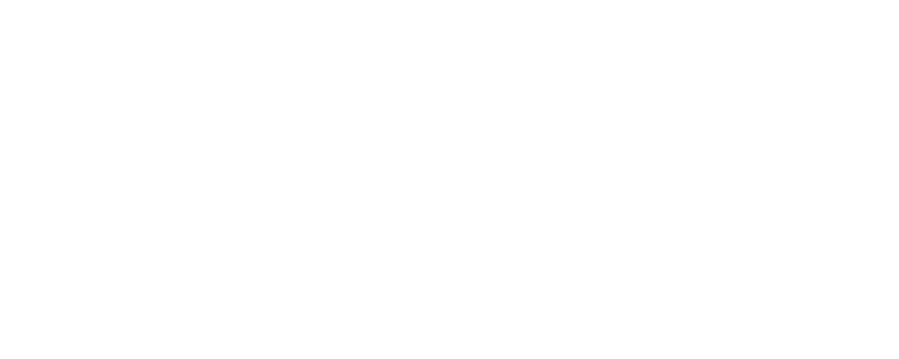

('min/max stim:', -185.55896648628519, 858.64996317371015)
(100, 30)


<IPython.core.display.Javascript object>


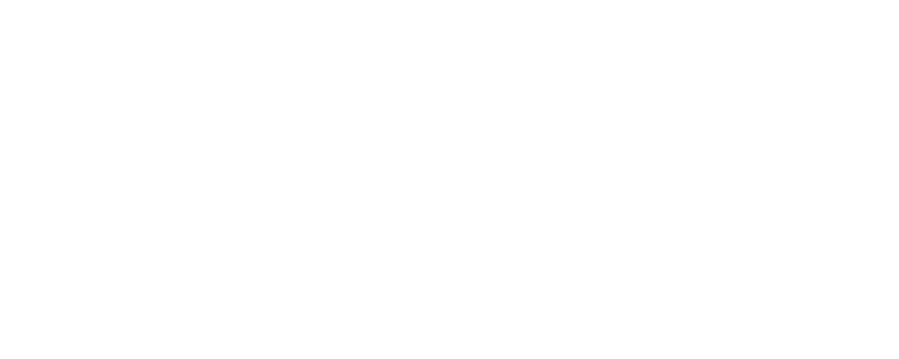

('min/max stim:', 20.231860362353661, 413.48605313369842)
(100, 30)


<IPython.core.display.Javascript object>


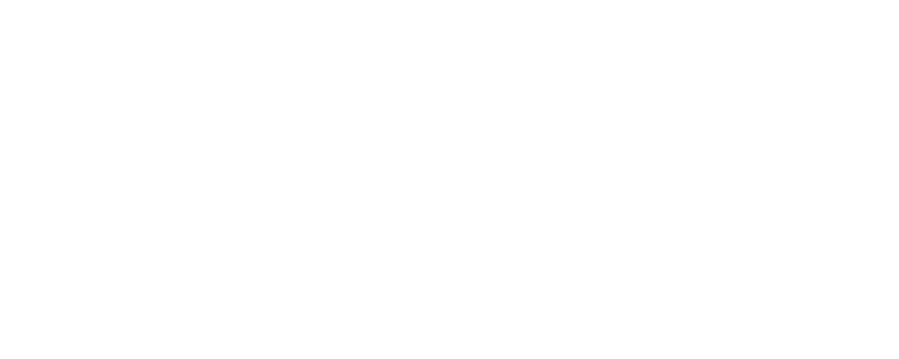

('min/max stim:', 22.356011234859476, 164.86257601591362)
(100, 30)


<IPython.core.display.Javascript object>


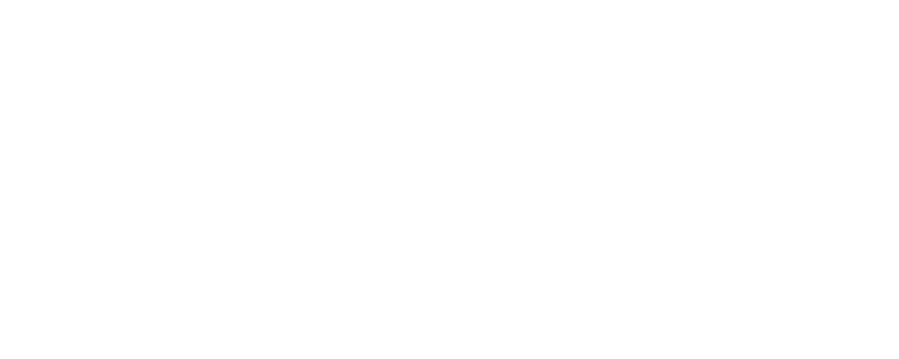

('min/max stim:', -60.191257564776606, 435.96476718810027)
(100, 30)


<IPython.core.display.Javascript object>


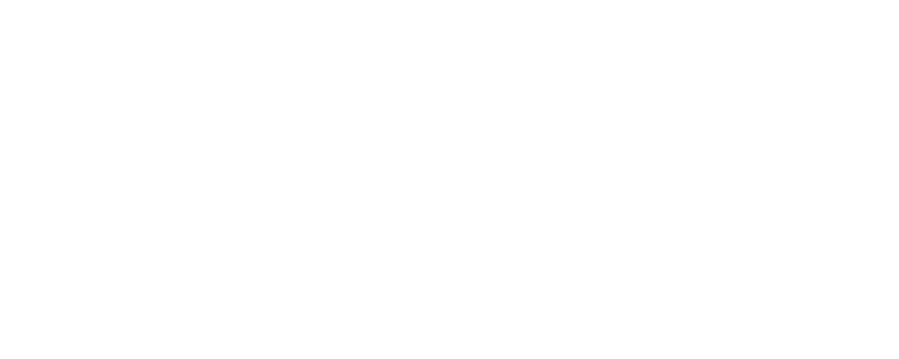

('min/max stim:', 6.6555922466629882, 380.68220784711076)
(100, 30)


<IPython.core.display.Javascript object>


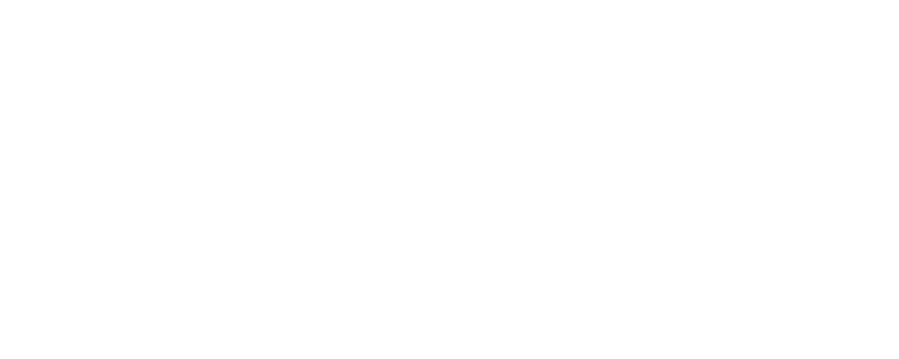

('min/max stim:', 18.839880582679697, 335.24839636820201)
(100, 30)


<IPython.core.display.Javascript object>


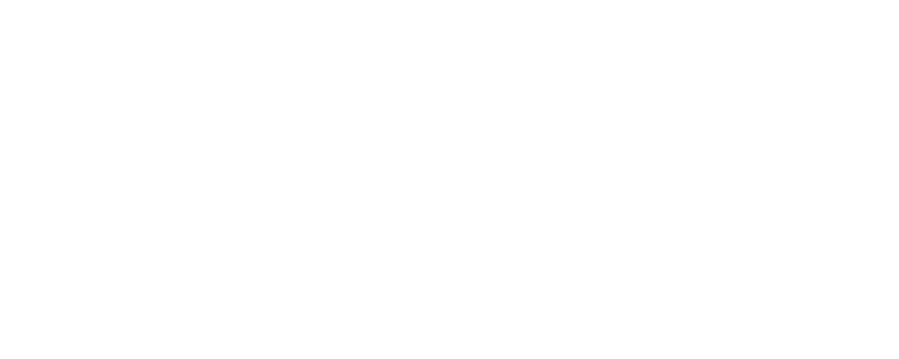

('min/max stim:', 17.881455872306635, 146.72083572125132)
(100, 30)


<IPython.core.display.Javascript object>


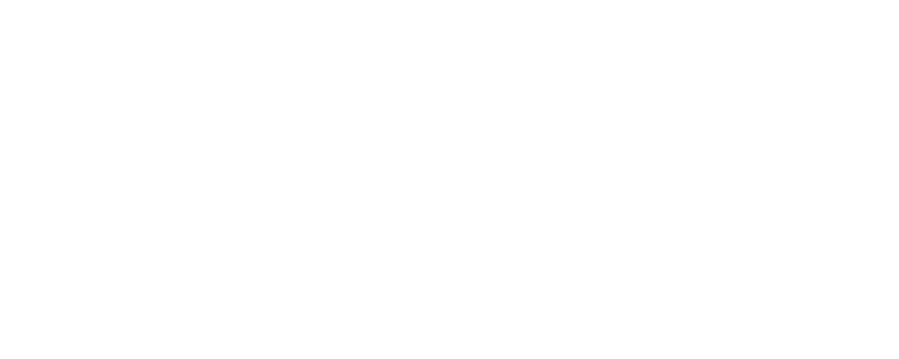

('min/max stim:', 45.410079365079326, 153.44643426706136)
(100, 30)


<IPython.core.display.Javascript object>


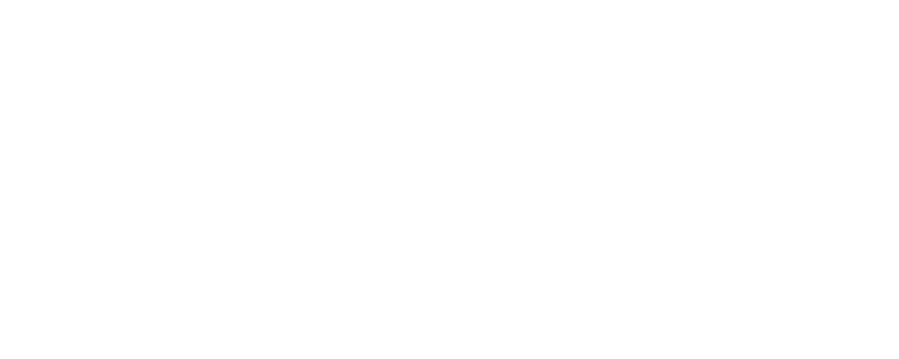

('min/max stim:', 47.852685268817432, 188.00234716621858)
(100, 30)


<IPython.core.display.Javascript object>


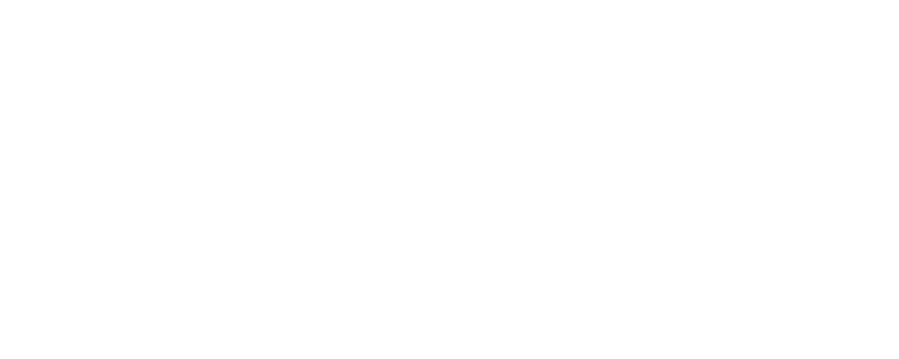

('min/max stim:', 34.801782760536526, 207.60881477148936)
(100, 30)


<IPython.core.display.Javascript object>


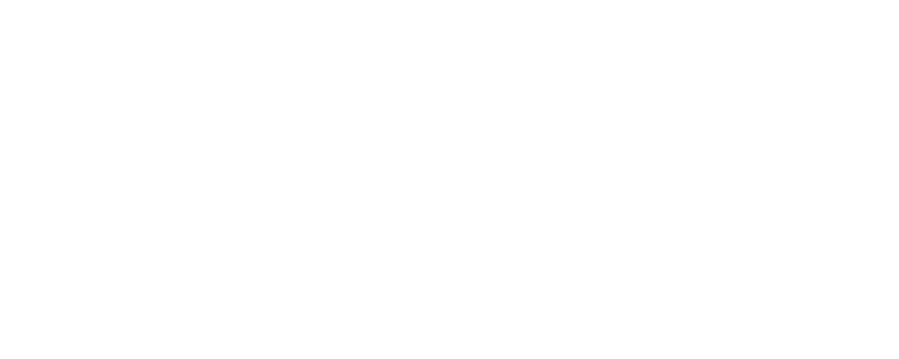

('min/max stim:', 42.931181956829008, 226.40304634834484)
(100, 30)


<IPython.core.display.Javascript object>


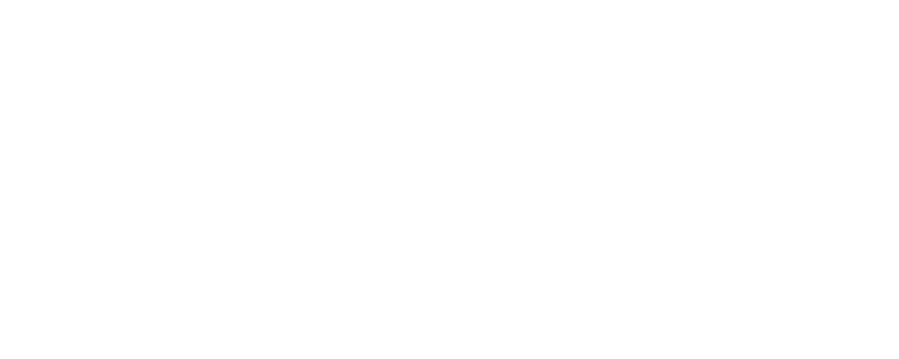

('min/max stim:', 54.136681629657041, 191.00554413786929)
(100, 30)


<IPython.core.display.Javascript object>


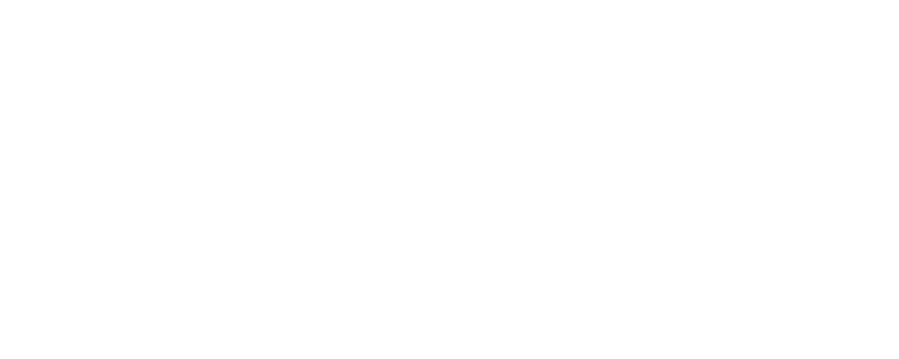

('min/max stim:', 39.820132009458376, 333.2992653086684)
(100, 30)


<IPython.core.display.Javascript object>


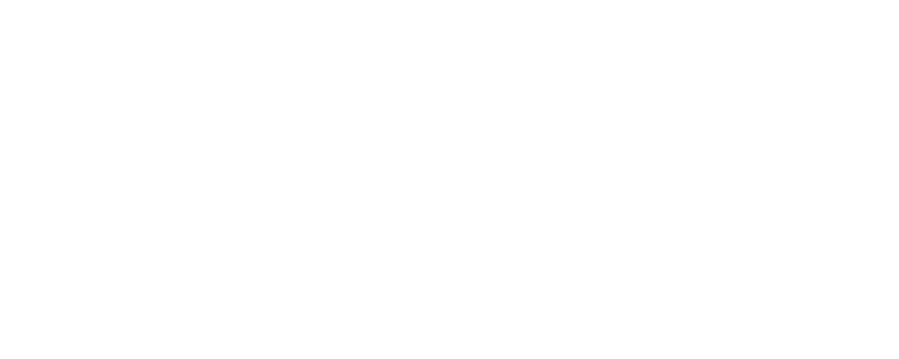

('min/max stim:', 51.280602041366585, 223.52322152226017)
(100, 30)


<IPython.core.display.Javascript object>


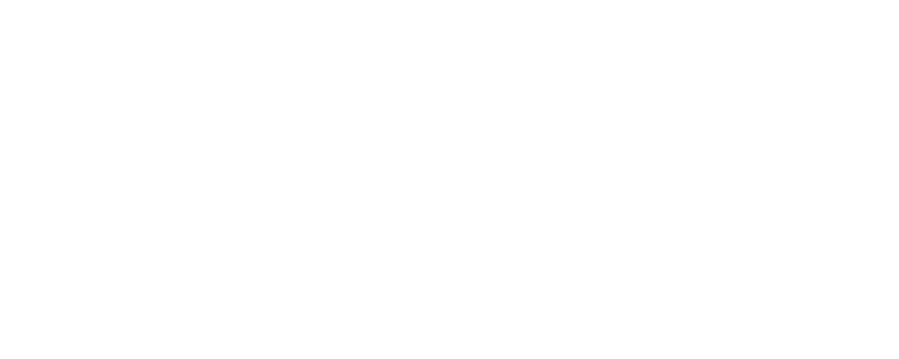

('min/max stim:', 48.531314562239508, 212.73095328142381)
(100, 30)


<IPython.core.display.Javascript object>


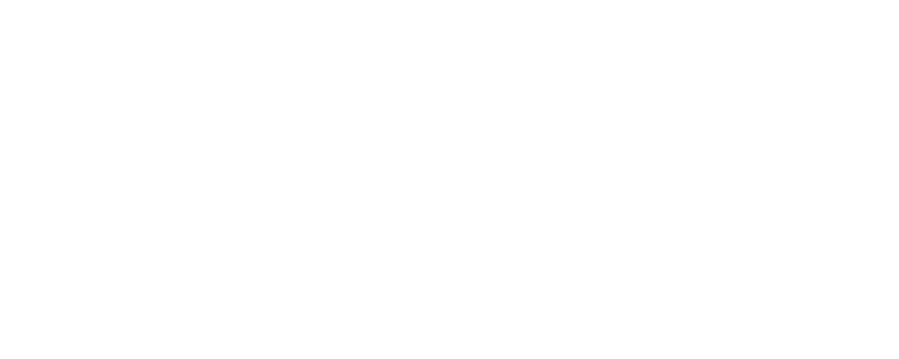

('min/max stim:', 1.8743110886380387, 775.0959753308905)
(100, 30)


<IPython.core.display.Javascript object>


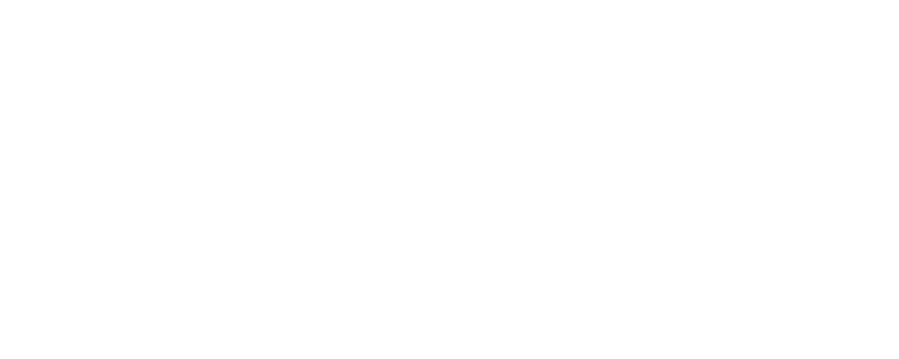

('min/max stim:', 47.319604095550147, 363.35867096840036)
(100, 30)


<IPython.core.display.Javascript object>


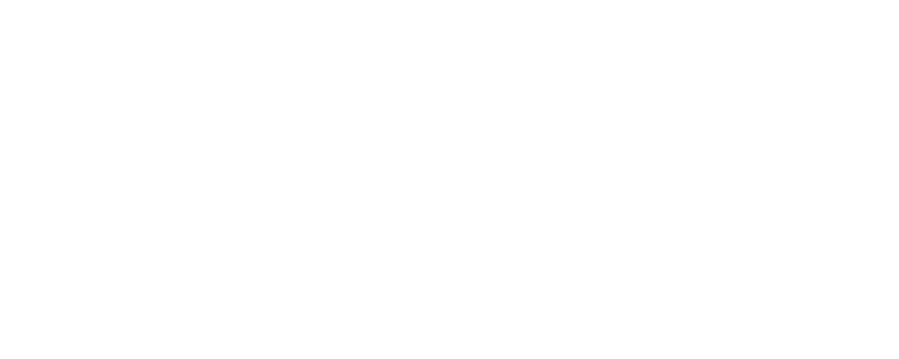

('min/max stim:', 59.336567602510343, 183.91936897038806)
(100, 30)


<IPython.core.display.Javascript object>


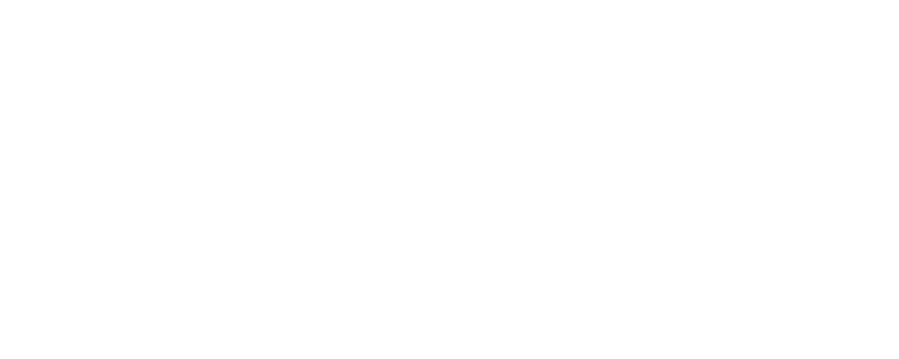

('min/max stim:', 41.299299931939785, 146.71834845115768)
(100, 30)


<IPython.core.display.Javascript object>


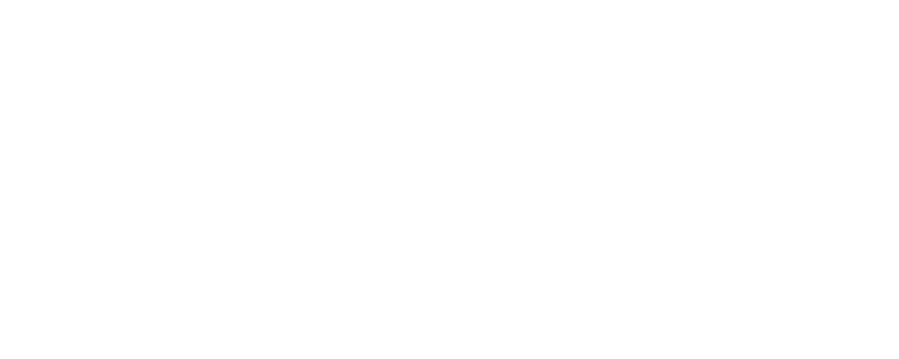

('min/max stim:', 58.364347837906863, 217.57844408338957)
(100, 30)


<IPython.core.display.Javascript object>


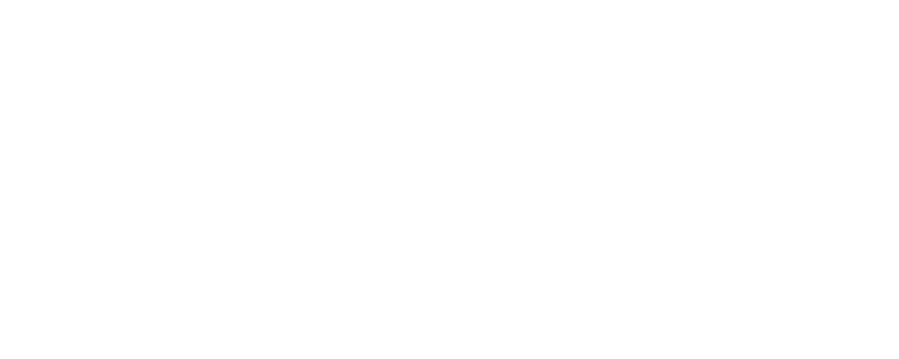

('min/max stim:', 47.941118985991046, 235.98518274139246)
(100, 30)


<IPython.core.display.Javascript object>


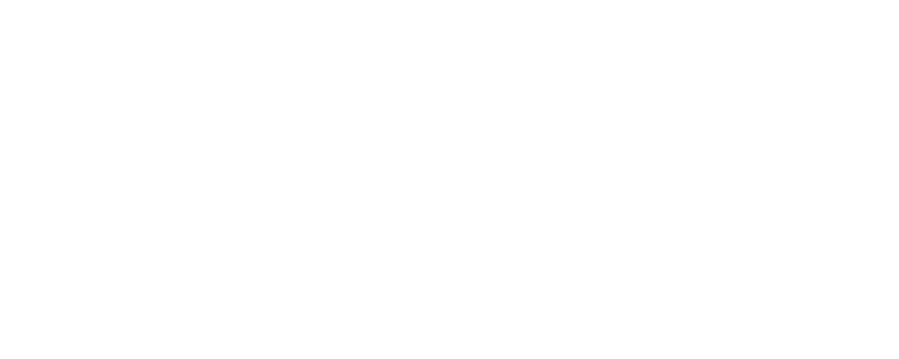

('min/max stim:', 21.300345413773133, 228.75825802951397)
(100, 30)


<IPython.core.display.Javascript object>


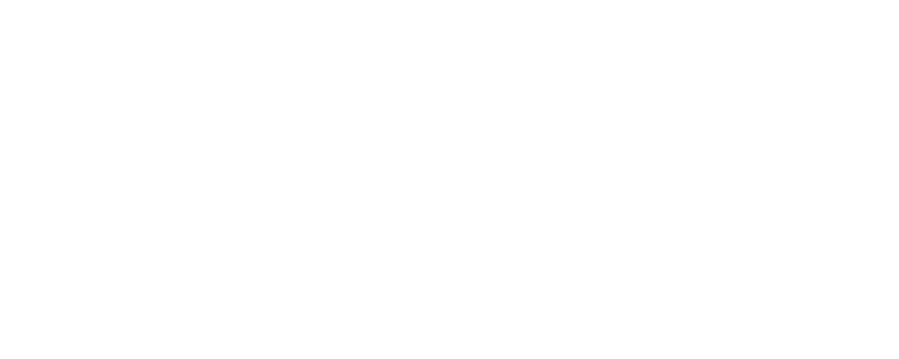

('min/max stim:', 21.341839529697442, 220.48859776268785)
(100, 30)


<IPython.core.display.Javascript object>


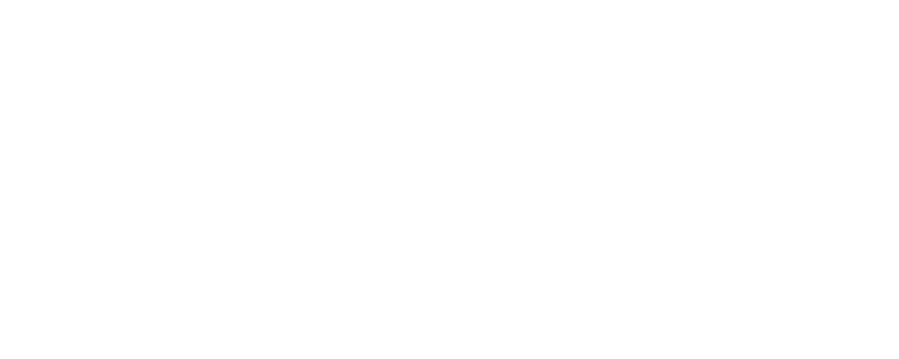

('min/max stim:', 51.425410755082623, 151.13599265517996)
(100, 30)


<IPython.core.display.Javascript object>


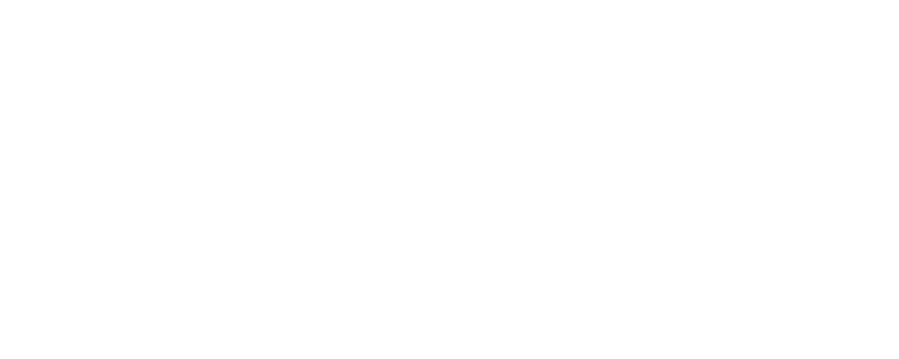

('min/max stim:', 42.83226304162266, 353.56804515371334)
(100, 30)


<IPython.core.display.Javascript object>


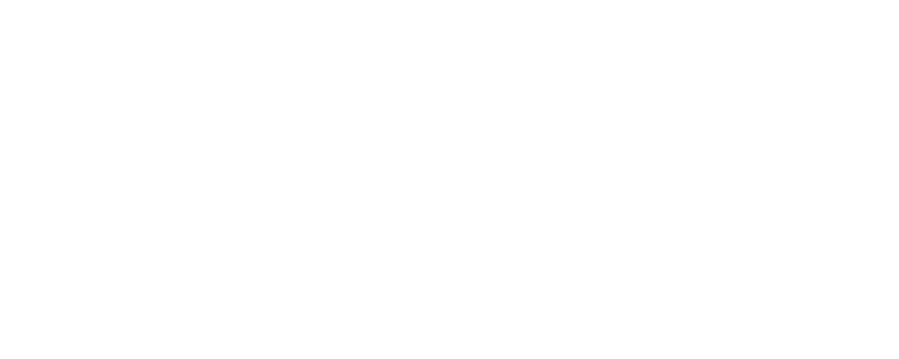

('min/max stim:', 17.923517562124434, 463.50301894785889)
(100, 30)


<IPython.core.display.Javascript object>


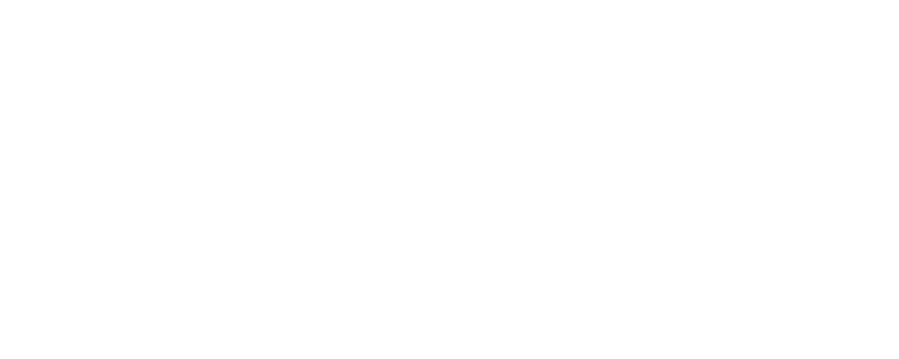

('min/max stim:', 57.714907704823709, 298.96950624305623)
(100, 30)


<IPython.core.display.Javascript object>


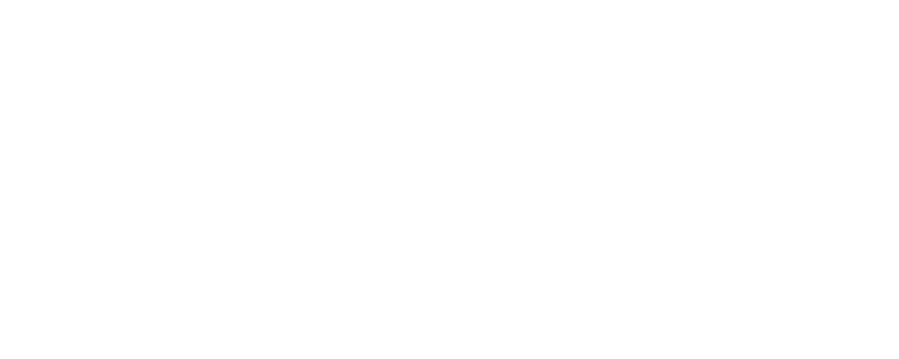

('min/max stim:', -22.146520943638883, 831.14501201681753)
(100, 30)


<IPython.core.display.Javascript object>


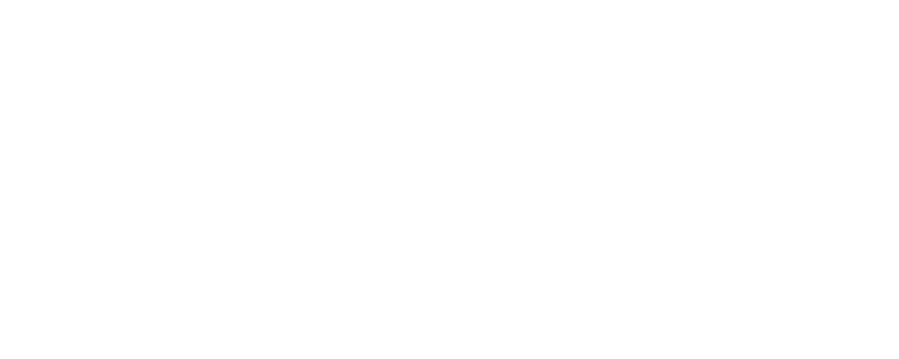

('min/max stim:', -142.97535920730741, 896.46183243845587)
(100, 30)


<IPython.core.display.Javascript object>


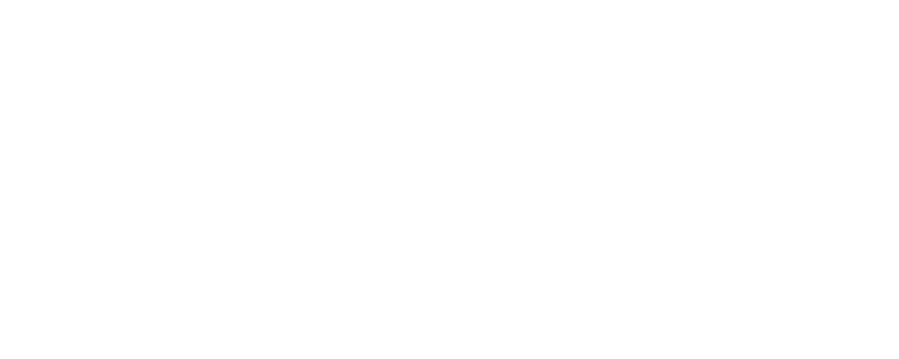

('min/max stim:', -78.383995835836089, 571.81458166676066)
(100, 30)


<IPython.core.display.Javascript object>


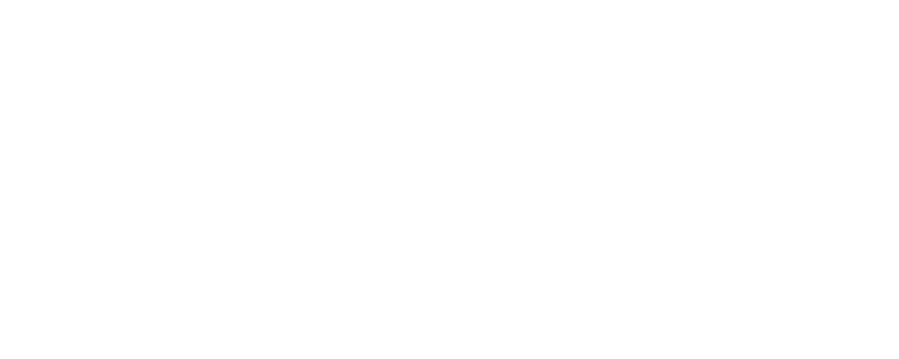

('min/max stim:', -20.302359438662723, 771.80649019556597)
(100, 30)


<IPython.core.display.Javascript object>


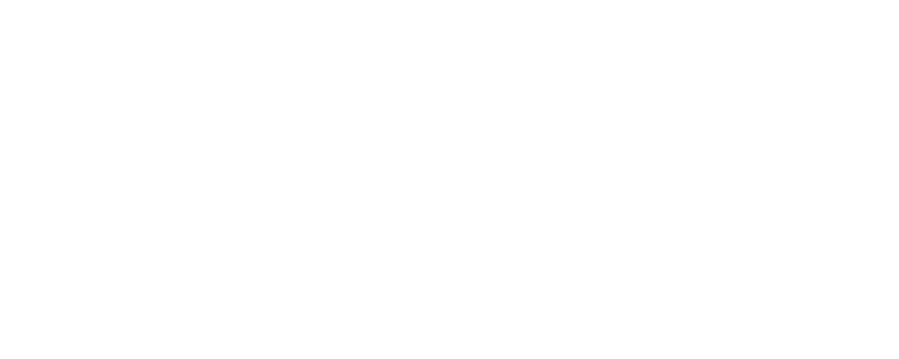

('min/max stim:', 42.79268288141877, 320.73588486842101)
(100, 30)


<IPython.core.display.Javascript object>


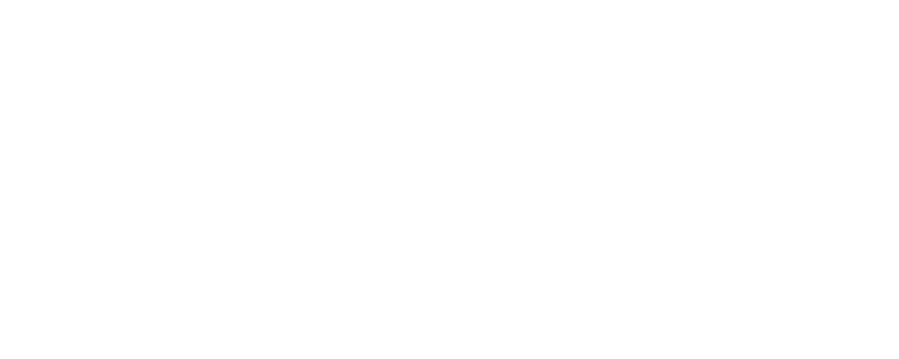

('min/max stim:', 55.172993725688954, 212.29629907052808)
(100, 30)


<IPython.core.display.Javascript object>


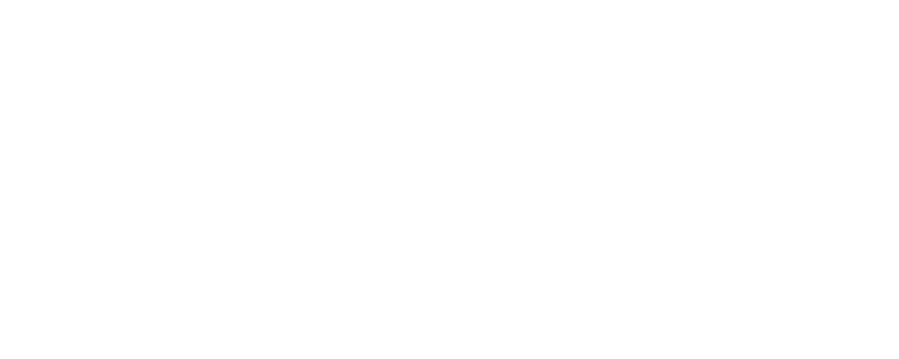

('min/max stim:', 16.931575385015144, 149.36819602111674)
(100, 30)


<IPython.core.display.Javascript object>


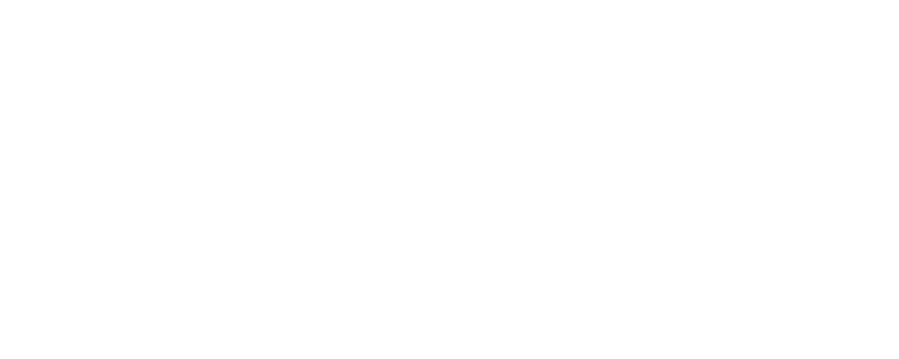

('min/max stim:', 25.187572644871995, 94.98312679127153)
(100, 30)


<IPython.core.display.Javascript object>


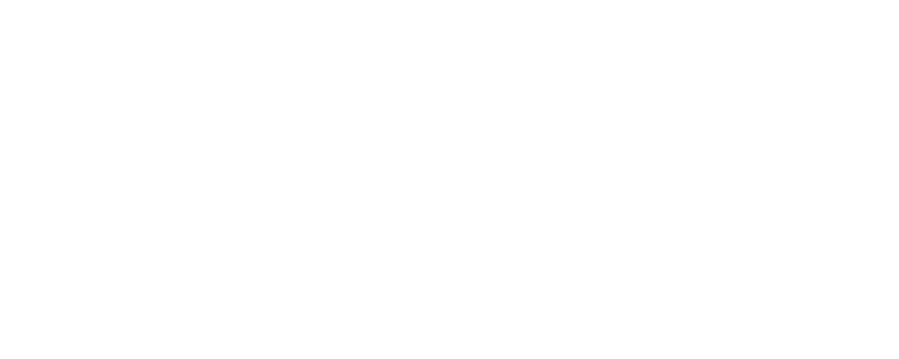

('min/max stim:', -3.1908562241502043, 320.8228325639916)
(100, 30)


<IPython.core.display.Javascript object>


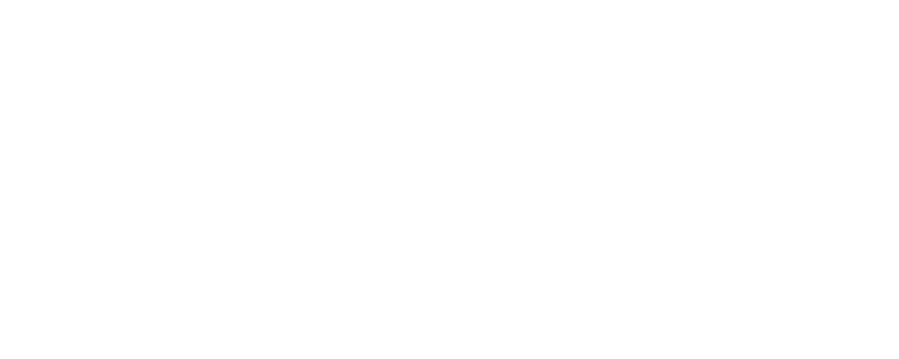

('min/max stim:', -16.428713257223627, 371.84304250341393)
(100, 30)


<IPython.core.display.Javascript object>


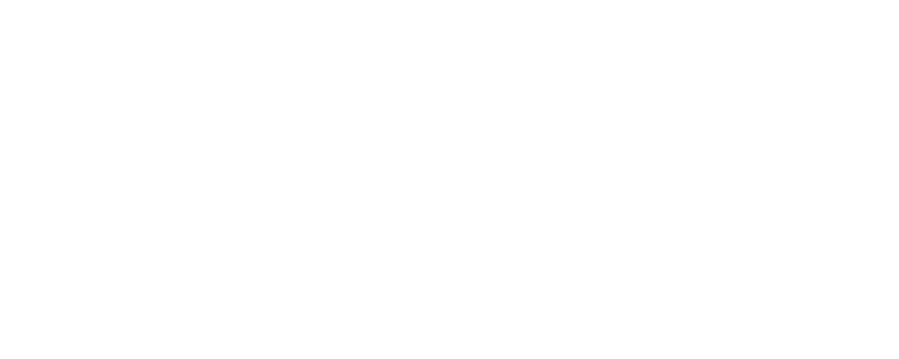

('min/max stim:', 39.968393233795787, 232.26983644209932)
(100, 30)


<IPython.core.display.Javascript object>


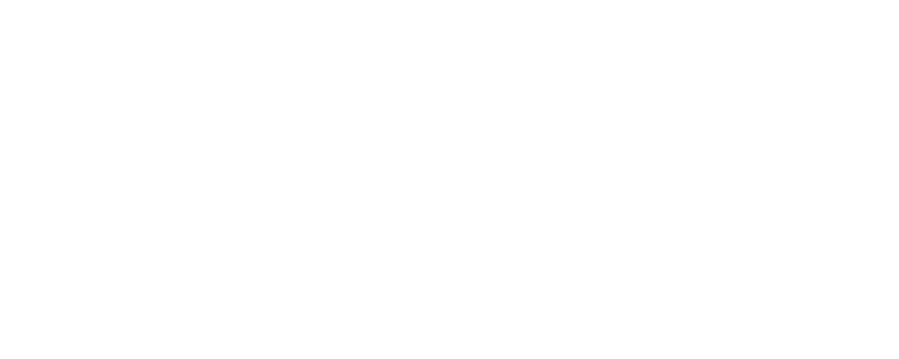

('min/max stim:', 39.223353168379191, 135.57062382504475)
(100, 30)


<IPython.core.display.Javascript object>


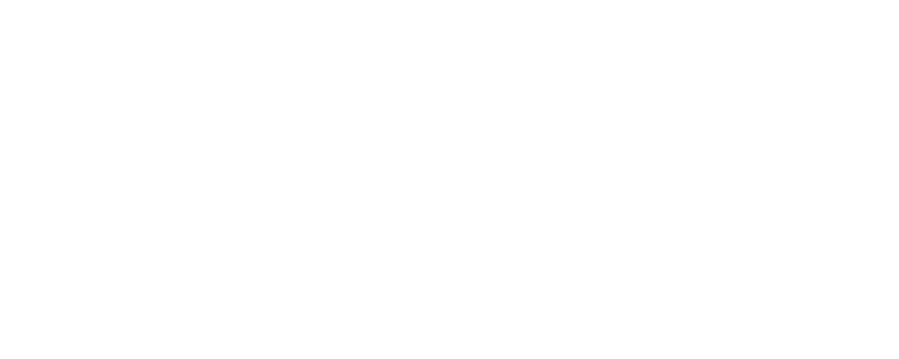

('min/max stim:', 41.284530284178707, 150.35237409652495)
(100, 30)


<IPython.core.display.Javascript object>


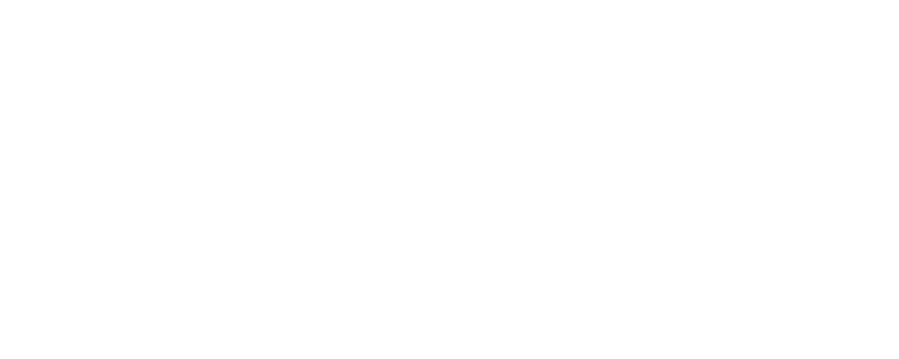

('min/max stim:', 16.665893186531463, 155.93112361111113)
(100, 30)


<IPython.core.display.Javascript object>


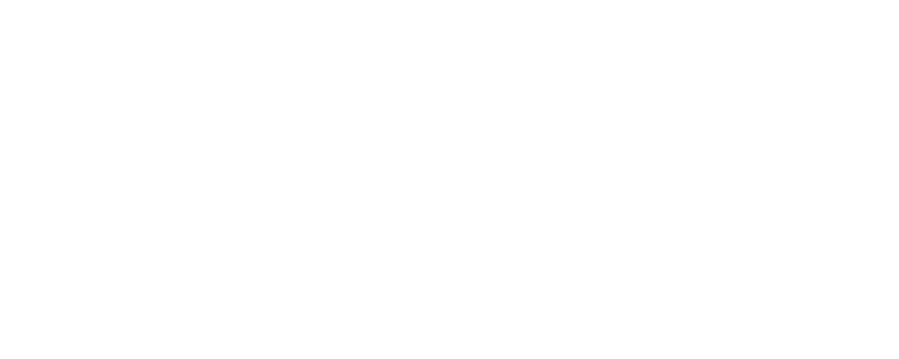

('min/max stim:', 25.578904653214895, 388.51434815977319)
(100, 30)


<IPython.core.display.Javascript object>


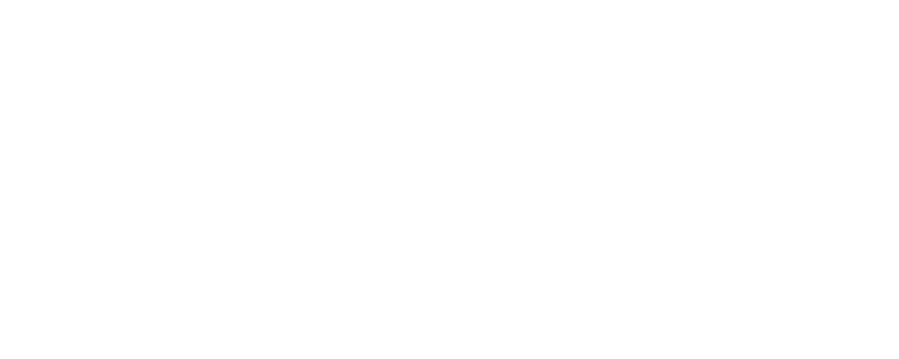

('min/max stim:', 49.251528190076314, 152.81604664188299)
(100, 30)


<IPython.core.display.Javascript object>


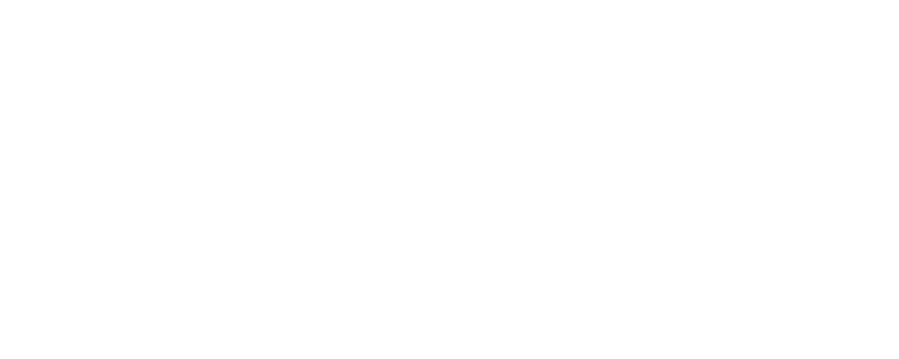

('min/max stim:', 25.41436846918489, 222.57091864480745)
(100, 30)


<IPython.core.display.Javascript object>


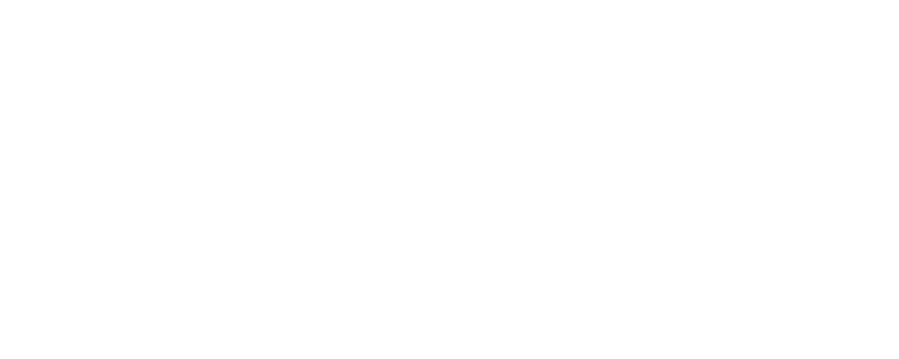

('min/max stim:', 25.00176990205771, 223.59130712799018)
(100, 30)


<IPython.core.display.Javascript object>


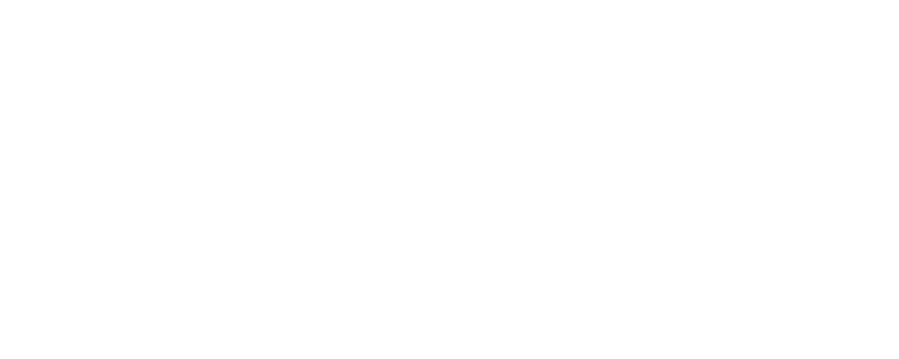

('min/max stim:', 49.408003394786689, 146.56645099549442)
(100, 30)


<IPython.core.display.Javascript object>


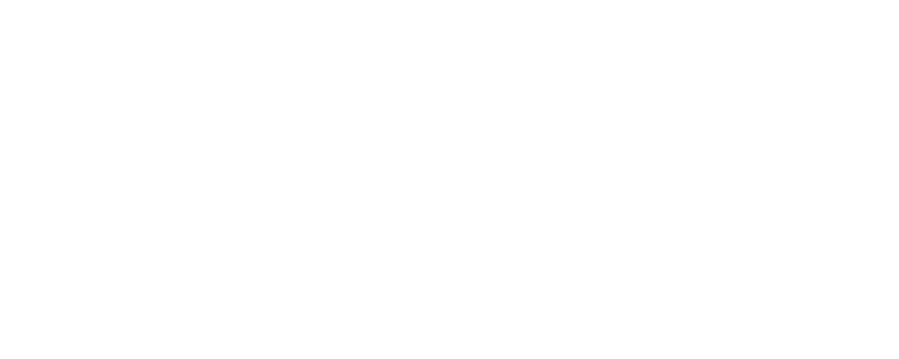

('min/max stim:', 37.886892084004806, 736.37620687346612)
(100, 30)


<IPython.core.display.Javascript object>


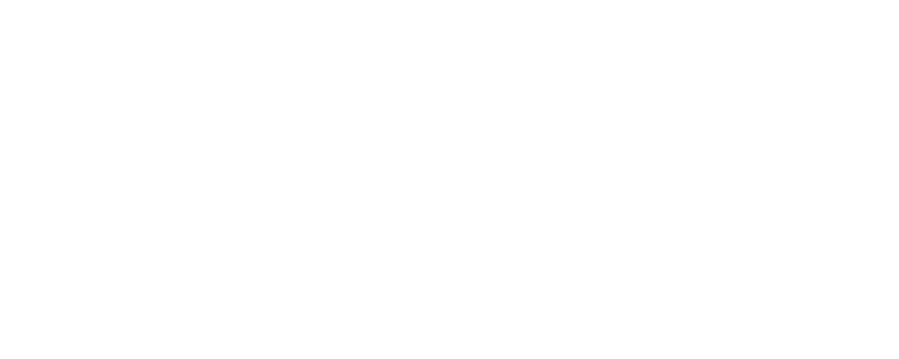

('min/max stim:', 57.054329402638231, 194.43432145292169)
(100, 30)

In [ ]:
pval_dict = {}

#roi = 30

for roi in range(len(gdf.groups)):

    roi_df = gdf.get_group(roi)


    resp_stim = np.vstack(roi_df.groupby(['config'])['meanstim'].apply(np.array).values)
    resp_bas = np.vstack(roi_df.groupby(['config'])['base_mean'].apply(np.array).values)

    min_stim = roi_df['meanstim'].min()
    max_stim = roi_df['meanstim'].max()
    print("min/max stim:", min_stim, max_stim)


    # Generate ROC curve 

    crit_vals = np.linspace(min_stim, max_stim)
    n_conditions, n_trials = resp_stim.shape

    #### Shuffle

    all_values = np.vstack([resp_stim, resp_bas])
    print(all_values.shape)

    # Shuffle values, group into stim and bas again

    n_iters = 1000
    shuff_auc = []
    for i in range(n_iters):
        X = shuffle(all_values.ravel())
        X = np.reshape(X, (n_conditions*2, n_trials))
        shuff_stim = X[0:n_conditions, :]
        shuff_bas = X[n_conditions:, :]
        p_hits, p_fas, crit_vals = get_hits_and_fas(shuff_stim, shuff_bas)

        shuff_auc.append(np.max([-np.trapz(p_hits[ci, :], x=p_fas[ci, :]) for ci in range(n_conditions)]))



    p_hits, p_fas, crit_vals = get_hits_and_fas(resp_stim, resp_bas)

    
    fig, ax = pl.subplots(1,3, figsize=(10,4))
    fig.patch.set_alpha(1.0)

    true_auc = []
    cond_labels = []
    for ci in range(len(curr_cfg_ixs)):
        ax[0].plot(p_fas[ci, :], p_hits[ci, :], color=colors[ci])
        true_auc.append(-np.trapz(p_hits[ci, :], x=p_fas[ci, :]))
        #cond_labels.append(sdf['ori'][curr_plot_cfgs[ci]])
    max_true_auc = np.max(true_auc)


    #ax[0].legend()
    ax[0].set_xlim([0, 1])
    ax[0].set_ylim([0, 1])
    ax[0].set_xlabel('p (bas > crit)')
    ax[0].set_ylabel('p (stim > crit)')
    sns.despine(offset=4, trim=True, ax=ax[0])


    ax[1].plot(sorted(true_auc, reverse=True))
    ax[1].set_xticks([]) #range(len(curr_cfg_ixs)))
    #ax[1].set_xticklabels(cond_labels)
    ax[1].set_ylabel('auc')
    ax[1].set_xlabel('sorted conditions')
    ax[1].set_ylim([0, 1.0])
    sns.despine(offset=4, trim=True, ax=ax[1])


    ax[2].hist(shuff_auc, color='k', alpha=0.5)
    ax[2].axvline(x=max_true_auc, color='r')
    ax[2].set_xlim([0.5, 1])
    pval = sum(shuff_auc >= max_true_auc)/ float(len(shuff_auc))
    ax[2].set_title('N iter=%i, p=%.3f' % (n_iters, pval), fontsize=8)
    ax[2].set_xlabel('max AUC')
    ax[2].set_ylabel('counts')
    sns.despine(trim=True, offset=4, ax=ax[2])

    pl.subplots_adjust(wspace=0.5, top=0.8, left=0.1, bottom=0.2)
    fig.suptitle('cell %i' % (int(roi+1)))

    label_figure(fig, data_identifier)

    pl.savefig(os.path.join(roi_figdir, 'roi%05d.png' % (int(roi+1))))

    pl.close()

    pval_dict.update({roi: {'max_auc': max_true_auc, 'pval': pval}})


<IPython.core.display.Javascript object>


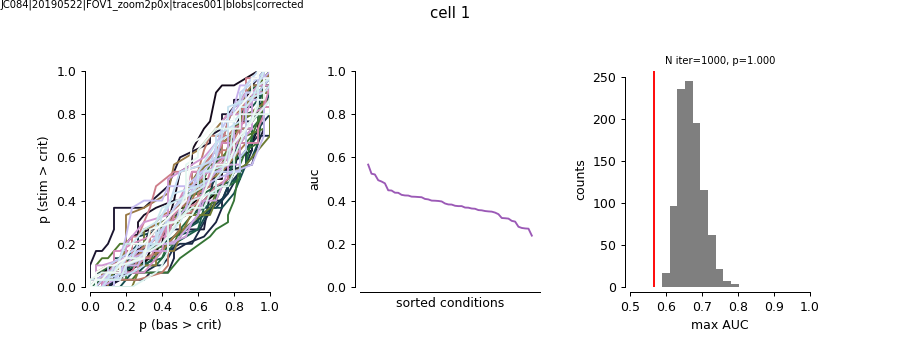

In [27]:

fig, ax = pl.subplots(1,3, figsize=(10,4))
fig.patch.set_alpha(1.0)

true_auc = []
cond_labels = []
for ci in range(len(curr_cfg_ixs)):
    ax[0].plot(p_fas[ci, :], p_hits[ci, :], color=colors[ci])
    true_auc.append(-np.trapz(p_hits[ci, :], x=p_fas[ci, :]))
    #cond_labels.append(sdf['ori'][curr_plot_cfgs[ci]])
max_true_auc = np.max(true_auc)


#ax[0].legend()
ax[0].set_xlim([0, 1])
ax[0].set_ylim([0, 1])
ax[0].set_xlabel('p (bas > crit)')
ax[0].set_ylabel('p (stim > crit)')
sns.despine(offset=4, trim=True, ax=ax[0])


ax[1].plot(sorted(true_auc, reverse=True))
ax[1].set_xticks([]) #range(len(curr_cfg_ixs)))
#ax[1].set_xticklabels(cond_labels)
ax[1].set_ylabel('auc')
ax[1].set_xlabel('sorted conditions')
ax[1].set_ylim([0, 1.0])
sns.despine(offset=4, trim=True, ax=ax[1])


ax[2].hist(shuff_auc, color='k', alpha=0.5)
ax[2].axvline(x=max_true_auc, color='r')
ax[2].set_xlim([0.5, 1])
pval = sum(shuff_auc >= max_true_auc)/ float(len(shuff_auc))
ax[2].set_title('N iter=%i, p=%.3f' % (n_iters, pval), fontsize=8)
ax[2].set_xlabel('max AUC')
ax[2].set_ylabel('counts')
sns.despine(trim=True, offset=4, ax=ax[2])

pl.subplots_adjust(wspace=0.5, top=0.8, left=0.1, bottom=0.2)
fig.suptitle('cell %i' % (int(roi+1)))

label_figure(fig, data_identifier)

pl.savefig(os.path.join(roi_figdir, 'roi%05d.png' % (int(roi+1))))

#pl.close()

pval_dict.update({roi: {'max_auc': max_true_auc, 'pval': pval}})



# Save results of shuffle test and plot summary figure

In [30]:
import cPickle as pkl
import json

In [31]:
fmts = ['pkl', 'json']

for fmt in fmts:
    results_outfile = os.path.join(roc_dir, 'roc_results.%s' % fmt)
    if fmt == 'pkl':
        with open(results_outfile, 'wb') as f:
            pkl.dump(pval_dict, f, protocol=pkl.HIGHEST_PROTOCOL)
    elif fmt == 'json':
        with open(results_outfile, 'w') as f:
            json.dump(pval_dict, f, sort_keys=True, indent=4)



In [32]:
thr_rois = [r for r, res in pval_dict.items() if res['pval'] <= 0.05]

<IPython.core.display.Javascript object>


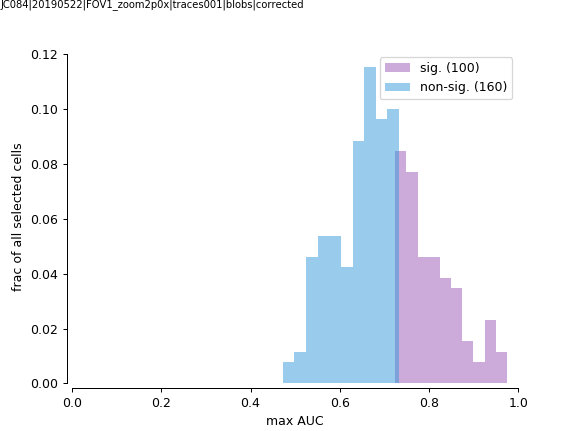

In [33]:
sig_aucs = [res['max_auc'] for r, res in pval_dict.items() if r in thr_rois]
nonsig_aucs = [res['max_auc'] for r, res in pval_dict.items() if r not in thr_rois]

fig = pl.figure()
fig.patch.set_alpha(1)
weights1 = np.ones_like(sig_aucs) / float(len(pval_dict.keys()))
weights2 = np.ones_like(nonsig_aucs) / float(len(pval_dict.keys())) #float(len(nonsig_aucs))

pl.hist(sig_aucs, alpha=0.5, label='sig. (%i)' % len(sig_aucs), weights=weights1, normed=0)
pl.hist(nonsig_aucs, alpha=0.5, label='non-sig. (%i)' % len(nonsig_aucs), weights=weights2, normed=0)
pl.legend()

pl.ylabel('frac of all selected cells')
pl.xlabel('max AUC')
pl.xlim([0, 1])

sns.despine(offset=4, trim=True)

label_figure(fig, data_identifier)

pl.savefig(os.path.join(roc_dir, 'max_aucs.png'))


# Save list of rois that pass for quick ref:
with open(os.path.join(roc_dir, 'significant_rois.json'), 'w') as f:
    json.dump(thr_rois, f)

In [509]:
thr_rois

[1,
 3,
 4,
 5,
 6,
 7,
 9,
 10,
 11,
 12,
 14,
 16,
 17,
 18,
 19,
 21,
 25,
 26,
 27,
 29,
 30,
 33,
 35,
 40,
 42,
 44,
 45,
 46,
 49,
 51,
 52,
 54,
 55,
 56,
 57,
 59,
 61,
 63,
 65,
 67,
 68,
 69,
 70,
 73,
 74,
 75,
 78,
 79,
 81,
 88,
 91,
 92,
 93,
 97,
 98,
 101,
 102,
 106,
 108,
 110,
 112,
 114,
 119,
 120,
 121,
 122,
 123,
 125,
 132,
 135,
 137,
 138,
 139,
 140,
 142,
 143,
 144,
 147,
 148,
 150,
 151,
 152,
 153,
 155,
 156,
 160,
 163,
 165,
 166,
 168,
 170,
 171,
 175,
 176,
 177,
 179,
 182,
 183,
 188,
 189,
 193,
 203,
 205,
 206,
 210,
 212,
 214,
 215,
 216,
 217,
 221,
 224,
 231,
 232,
 233,
 234,
 241,
 242,
 243,
 246,
 247,
 250,
 252,
 255,
 258]

<IPython.core.display.Javascript object>


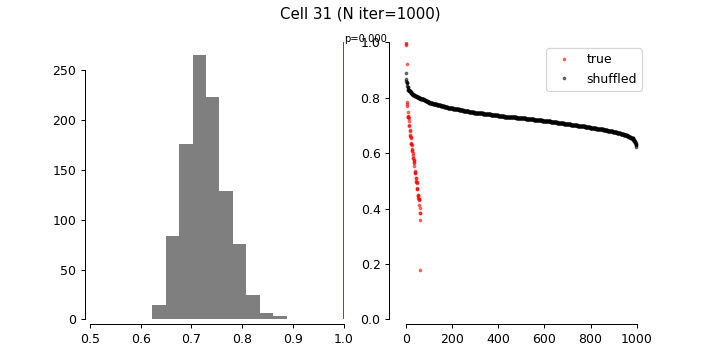

In [474]:
# fig, ax = pl.subplots(1,2, figsize=(8,4))
# ax[0].hist(shuff_auc, color='k', alpha=0.5)
# ax[0].axvline(x=max_true_auc, color='r')
# ax[0].set_xlim([0.5, 1])
# pval = sum(shuff_auc >= max_true_auc)/ float(len(shuff_auc))
# ax[0].text(max_true_auc, ax[0].get_ylim()[1], 'p=%.3f' % pval, fontsize=8)

# # ax[1].plot(sorted(true_auc, reverse=True), 'ro', markersize=2, alpha=0.5, label='true')
# # ax[1].plot(sorted(shuff_auc, reverse=True), 'ko', markersize=2, alpha=0.5, label='shuffled')
# # ax[1].legend()
# # ax[1].set_ylim([0, 1])


# fig.suptitle('Cell %i (N iter=%i)' % (int(roi+1), n_iters))
# sns.despine(trim=True, offset=4)

<IPython.core.display.Javascript object>


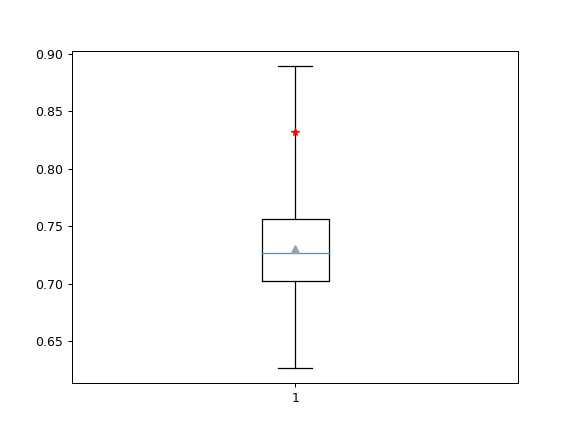

In [381]:
# pl.figure()
# pl.boxplot(shuff_auc, showmeans=True, whis = 99)
# pl.plot(1, max_true_auc, 'r*')

# Visualize some summary stats

In [34]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [37]:
# Load data:
trace_type = 'dff'
exp = util.Experiment(experiment_name, animalid, session, fov, traceid) #, trace_type=trace_type)
exp.load(trace_type=trace_type)

exp.data.traces, exp.data.labels = util.check_counts_per_condition(exp.data.traces, exp.data.labels)
gdf = resp.group_roidata_stimresponse(exp.data.traces[thr_rois], exp.data.labels)

... [combined_blobs_static] getting data path.
[blobs] creating experiment object.
... loading data array (blobs - datasets.npz)


#### Look at distribution of dF/F values

In [38]:
rseponse_type = 'meanstim'

df = pd.concat([pd.DataFrame(roidf[rseponse_type].values, columns=[roi],
                                      index=roidf['config']) for roi, roidf in gdf], axis=1)

<IPython.core.display.Javascript object>


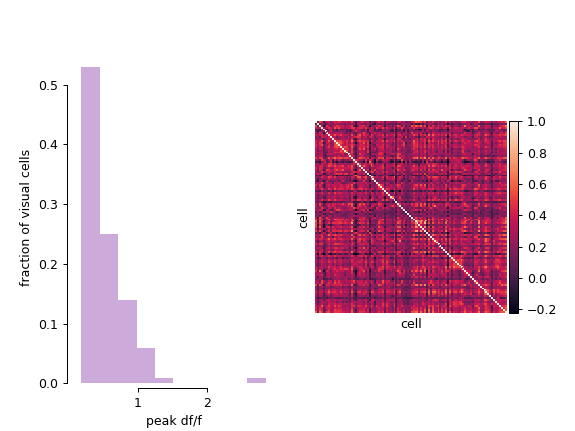

Text(321.268,0.5,u'cell')

In [39]:
fig, axes = pl.subplots(1,2)

ax = axes[0]
weights = np.ones_like(df.max()) / float(len(df.max()))
ax.hist(df.max(), weights=weights, alpha=0.5)
ax.set_xlabel('peak df/f')
ax.set_ylabel('fraction of visual cells')
sns.despine(trim=True, offset=4, ax=ax)

ax = axes[1]
im = sns.heatmap(df.corr(), cbar=False) #cbar_kws = dict(use_gridspec=False,location="right"))
ax.set_aspect('equal')
div = make_axes_locatable(ax)
cax = div.append_axes("right", size="5%", pad=0.02)
cbar = pl.colorbar(ax.get_children()[0], cax = cax, orientation = 'vertical')
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('cell')
ax.set_ylabel('cell')


<IPython.core.display.Javascript object>


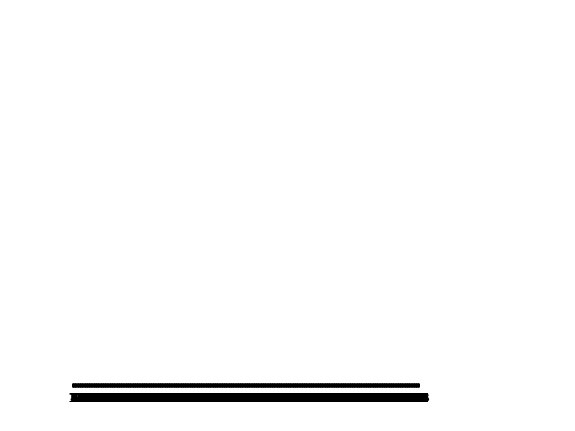

{'boxes': [<matplotlib.lines.Line2D at 0x7f6e24f156d0>,
  ...],
 'caps': [<matplotlib.lines.Line2D at 0x7f6e24f15fd0>,
  ...],
 'fliers': [<matplotlib.lines.Line2D at 0x7f6e24ea2c10>,
  ...],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f6e24ea2810>,
  ...],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f6e24f15790>,
  ...]}

In [594]:
pl.figure()
pl.boxplot(df)

<IPython.core.display.Javascript object>


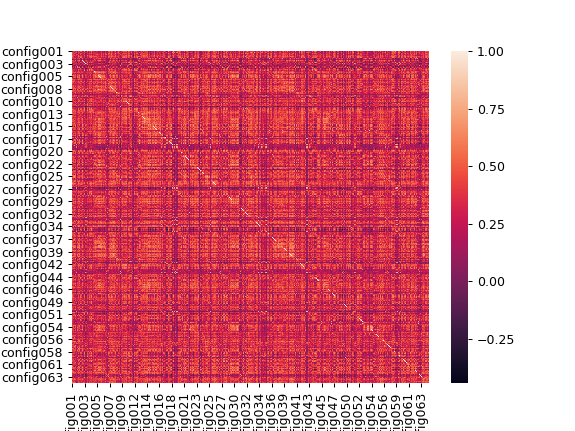

In [592]:
pl.figure()
sns.heatmap(df.T.corr())

# Compare to other tests

In [537]:
roi = 30
stim_values = gdf.get_group(roi)['meanstim']
base_values = gdf.get_group(roi)['base_mean']

In [540]:
import scipy.stats

In [547]:
ttest_dict = {}
for roi in range(len(gdf.groups)):
    stim_values = gdf.get_group(roi)['meanstim']
    base_values = gdf.get_group(roi)['base_mean']
    t, p = scipy.stats.ttest_rel(stim_values, base_values)
    
    ttest_dict.update({roi: {'t-score': t, 'p-value': p}})

In [554]:
ttest_rois = [r for r, res in ttest_dict.items() if res['p-value'] <= 0.01]
print(len(ttest_rois))

234


In [555]:
ttest_rois


[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 9,
 10,
 11,
 12,
 14,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 33,
 34,
 35,
 36,
 37,
 38,
 40,
 41,
 42,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 101,
 102,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 114,
 115,
 116,
 117,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 158,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 182,
 183,
 184,
 185,
 186,
 187,
 188,
 189,
 190,
 191,
 192,
 193,
 194,
 195,
 197,
 198,
 199,
 200,
 201,
 202,
 203,
 204,
 205,
